In [1]:
import scipy 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_sequence = 100
sequence_length = 1000
generator = np.random.default_rng(seed=0)

(array([ 2.,  0., 12., 14., 14., 17., 16.,  8.,  9.,  8.]),
 array([-1.16251539, -0.94614422, -0.72977305, -0.51340188, -0.29703072,
        -0.08065955,  0.13571162,  0.35208279,  0.56845396,  0.78482512,
         1.00119629]),
 <BarContainer object of 10 artists>)

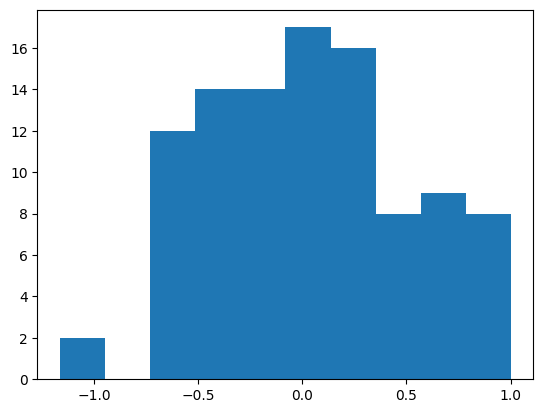

In [3]:
plt.hist(generator.normal(0, 0.5, 100))

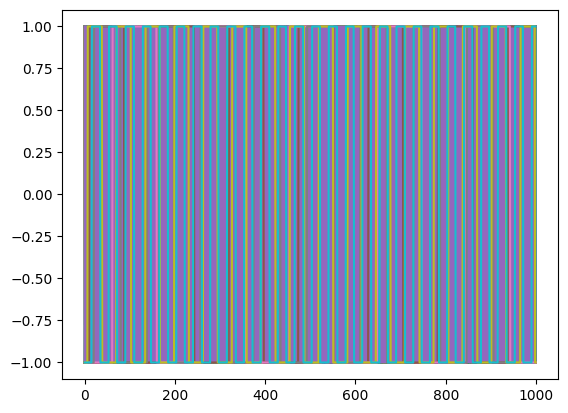

In [4]:
period = np.full(n_sequence, sequence_length/10)
period += 2*(generator.random(n_sequence)-0.5)*period

phase = generator.random(n_sequence)*period
t = np.linspace(phase, sequence_length+phase, sequence_length, endpoint=False).T
control = signal.square(2 * np.pi *((1/period)*t.T).T)

for i in range(n_sequence):
    plt.plot(np.linspace(0, sequence_length, sequence_length, endpoint=False), control[i])

(array([11.,  8.,  9.,  9.,  7., 15.,  5.,  8., 14., 14.]),
 array([  1.28177653,  21.05194584,  40.82211515,  60.59228446,
         80.36245377, 100.13262308, 119.90279239, 139.6729617 ,
        159.44313101, 179.21330032, 198.98346963]),
 <BarContainer object of 10 artists>)

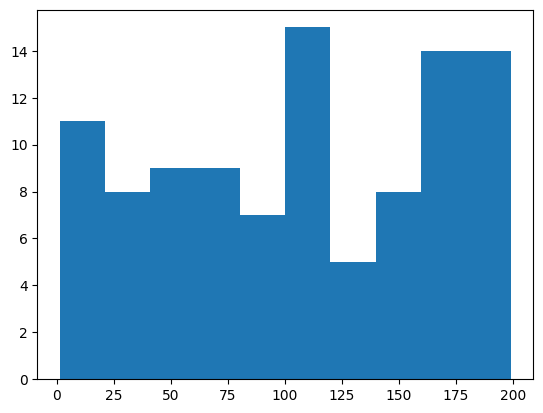

In [5]:
plt.hist(period)

In [6]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base

from hamilton import driver
import torch


d = driver.Builder().with_modules(base, shared).build()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

inputs = {"sequence_lenght": 1000,
        "n_sequence": 10000,
        "context_size": 200,
        "state_control":"periodic",
        "seed":0
                       }

In [8]:
outputs = d.execute(["toy1d_data"], inputs=inputs)

In [9]:
outputs["toy1d_data"]["state_decoded"].shape

(10000, 1000, 3)

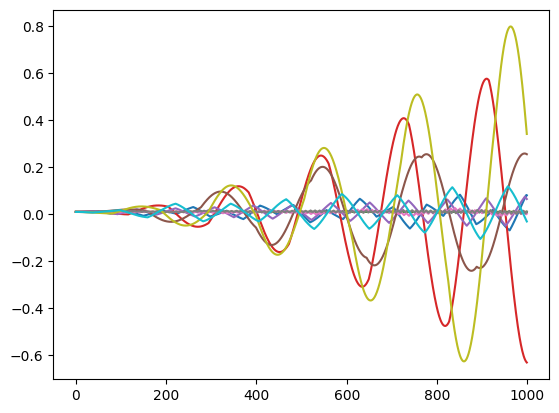

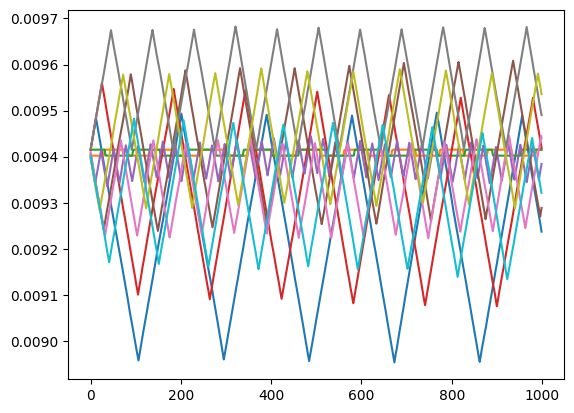

In [12]:
for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,0])
plt.show()



for i in range(10):
    plt.plot(outputs["toy1d_data"]["state_decoded"][i,:,2])
plt.show()


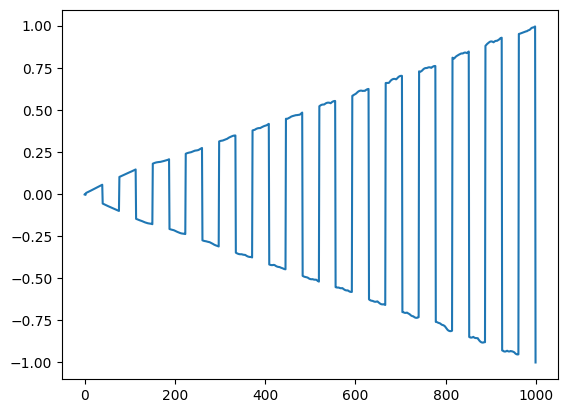

In [19]:
plt.plot(outputs["toy1d_data"]["state_control"][0,:,0])